In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))


### SHAP

In [2]:
import shap
import torch
import random
import numpy as np

import NEXUS
from NEXUS.model_int.SHAP_VAE.shap_explainer import shap_nexus
from NEXUS.cell_emb.model import OneViewVAE, TwoViewVAE, EncoderOnly

In [3]:
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

In [4]:
input_path = '../test_data/1_cell_emb_output/'
input_adata_path = input_path + "/VAE_embedded.h5ad"
input_model_param_path = input_path + "/VAE.pth"
output_path = '../test_data/3_SHAP_output/'

In [5]:
num_of_highly_variable_genes = 5579
cell_embedding_dim = 64
model = OneViewVAE(num_of_highly_variable_genes, cell_embedding_dim)

In [6]:
checkpoint = torch.load(input_model_param_path, map_location=torch.device('cpu'), weights_only=False)
model.load_state_dict(checkpoint.state_dict())

<All keys matched successfully>

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_encoder = EncoderOnly(model, 'oneview').to(device)

In [8]:
shap_nexus(model_encoder, input_adata_path, output_path, device, cell_num=1000)

F:\Anaconda\envs\pytorch\lib\site-packages\shap\explainers\_deep\deep_pytorch.py:255: UserWarning: unrecognized nn.Module: LayerNorm
  warnings.warn(f"unrecognized nn.Module: {module_type}")


KeyboardInterrupt: 

In [2]:
import scanpy as sc
from NEXUS.model_int.SHAP_VAE.shap_explainer import plot_rank_genes_as_bar

In [3]:
adata = sc.read_h5ad('E:/model_project/contrastive_learning/Graph_transformer/testis/cell_embedded_adata.h5ad')

In [4]:
sc.tl.rank_genes_groups(
    adata, 
    groupby='cell_type',  # 用于分组的obs列（如聚类结果、细胞类型）
    method='wilcoxon',  # 推荐用于单细胞数据的非参数检验
    n_genes=20,  # 每个组返回的差异基因数量
    key_added='rank_genes'  # 结果存储的键名（可选，默认是'rank_genes_groups'）
)

F:\Anaconda\envs\pytorch\lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
F:\Anaconda\envs\pytorch\lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
F:\Anaconda\envs\pytorch\lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
F:\Anaconda\envs\pytorch\lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
F:\Anaconda\envs\pytorch\lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
F:\Anaconda\envs\pytorch\lib\site-packages\scanpy\tools\_rank_gen

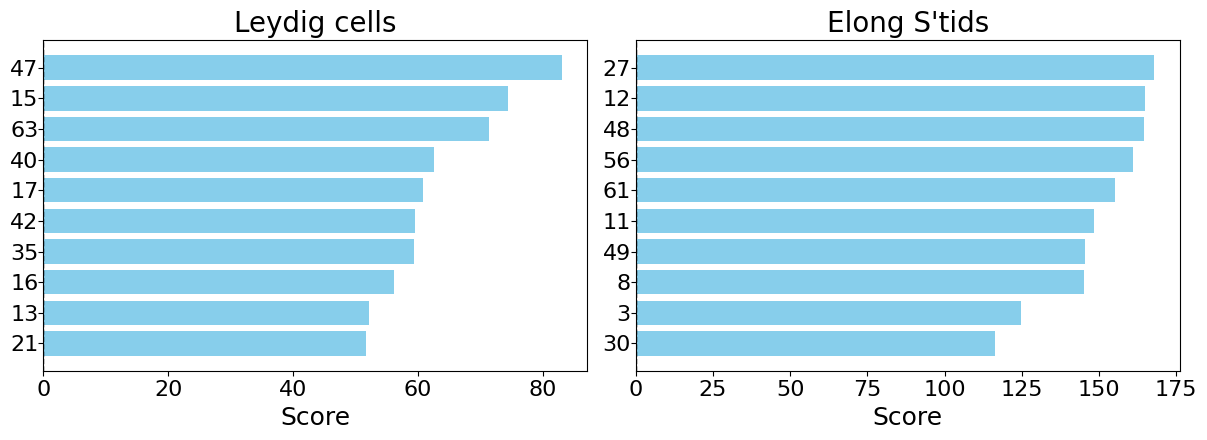

In [5]:
plot_rank_genes_as_bar(
    adata,
    key='rank_genes',
    groups=['Leydig cells', "Elong S'tids"],
    n_genes=10,
    sharey=False,
    fontsize=20,
    bar_height=0.8,
    y_spacing=0.05
)

### explain

In [2]:
import pickle
import numpy as np
import scanpy as sc
import pandas as pd
import gseapy as gp

In [3]:
from NEXUS.model_int.SHAP_VAE.shap_explainer import classify_shap_gene_correlations_from_adata, generate_shap_importances, get_gene_list
from NEXUS.model_int.SHAP_VAE.shap_explainer import plot_shap_selected_genes, plot_enrich_show, plot_genes_box

In [4]:
adata = sc.read_h5ad('E:/model_project/contrastive_learning/scRNA_VAE/testis/shap_adata.h5ad')
with open('E:/model_project/contrastive_learning/scRNA_VAE/testis/shap_values.pickle', 'rb') as f:
    shap_values = pickle.load(f)

In [6]:
latent_idx = 47
leiden_sub = ['KS','OA','iNOA']
mask_donors = list(np.unique((adata[adata.obs['sample_cluster'].isin(leiden_sub)]).obs['sample_ID']))
mask = (adata.obs['sample_ID'].isin(mask_donors)) & (adata.obs["cell_type"] == "Leydig cells")

In [7]:
adata_sub = adata[mask, :].copy()
shap_values_sub = shap_values[mask, :, :]

In [8]:
pos_genes, neg_genes = get_gene_list(adata_sub, shap_values_sub, latent_idx = latent_idx)

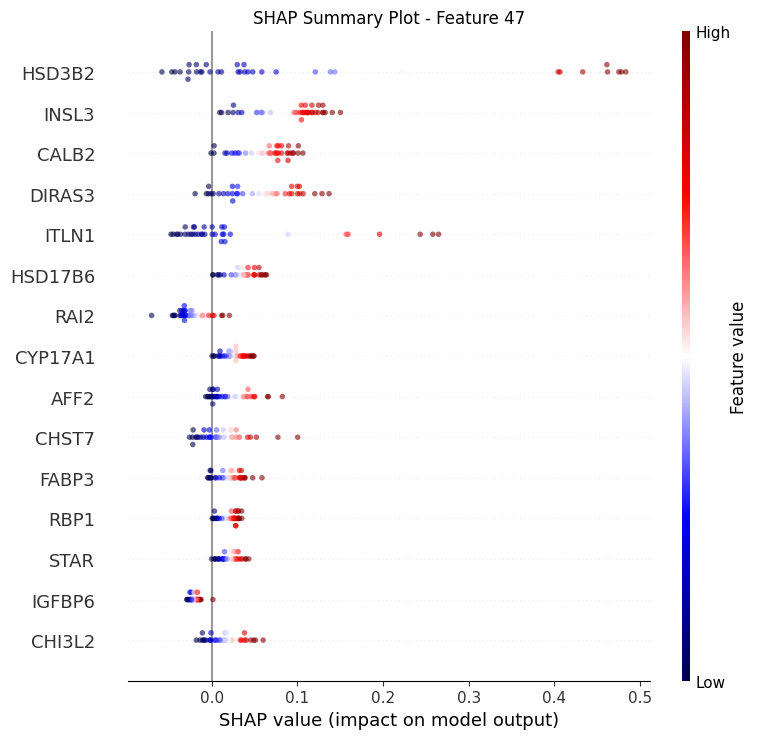

In [9]:
plot_shap_selected_genes(shap_values_sub, 
                         adata_sub, 
                         feature_num=latent_idx, 
                         selected_genes=pos_genes[:15])